In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# Get data
contacts_df = pd.read_csv('data/contacts.tsv', sep = '\t')
searches_df = pd.read_csv('data/searches.tsv', sep = '\t')

In [ ]:
contact_counts = contacts_df['id_guest'].value_counts()
contact_counts = pd.DataFrame({'id_guest': contact_counts.keys, 'n_contacts': contact_counts.values})
merged = pd.concat([searches_df, contact_counts], axis=1, join='outer').reindex(searches_df.index)
merged.drop('id_guest', axis=1, inplace=True)
merged['n_contacts'].fillna(0, inplace=True)
merged['n_nights'].fillna(1, inplace=True)
merged['filter_price_min'].fillna(0, inplace=True)
merged['filter_price_max'].fillna(1073741823, inplace=True)
merged['price_range'] = merged['filter_price_max'] - merged['filter_price_min']
merged['contacted'] = pd.Series(merged['n_contacts'] != 0)
merged['contacted'] = merged['contacted'].astype(int)

def get_month(date_time):
    if type(date_time) == str:
        return int(date_time[5:7])
    else:
        return date_time
    
merged['month_search'] = pd.Series(map(get_month, searches_df['ds_checkin']))
merged = merged[merged['month_search'].notna()]

merged.info()

In [ ]:
from sklearn.cluster import OPTICS
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, KMeans
from sklearn.preprocessing import normalize, StandardScaler
from kneed import KneeLocator


In [ ]:
features = ['n_searches', 'n_nights', 'n_guests_min', 'n_guests_max', 'contacted', 'price_range', 'n_contacts', 'month_search']

In [ ]:
scaler = StandardScaler()
X_val_scaled = scaler.fit_transform(merged[features]) # Scale to standardized score
X_val_normalized = normalize(X_val_scaled) # Get values to Normal distribution


In [ ]:
# Building the Kmeans Clustering model

def train_k_means(data: pd.DataFrame):
    #Find optimal n_clusters
    elbow_data_pts = []
    for num in range(1, 20):
        k_means = KMeans(init = "k-means++", n_clusters = num, n_init = 20)
        k_means.fit(data)
        elbow_data_pts.append(k_means.inertia_) #Error

    kneedle = KneeLocator(x = range(1, 20), y = elbow_data_pts, curve = "convex", direction = "decreasing")
    elbow_pt = kneedle.elbow

    #Do K-Means Cluster w/ optimal n_clusters
    true_k_means = KMeans(init = "k-means++", n_clusters = elbow_pt, n_init = 20)
    true_k_means.fit(data)

    return true_k_means

k_means = train_k_means(X_val_normalized)

In [ ]:
from sklearn.mixture import GaussianMixture
# gaussian = train_gaussian(X_val_normalized)
gaussian = GaussianMixture(n_components=3, random_state=69)
gaussian.fit(X_val_normalized)


In [ ]:
from sklearn.metrics import silhouette_score
print('K means silhouette score:', silhouette_score(X_val_normalized, k_means.labels_))

In [ ]:

print('Gaussian mixture silhouette score:', silhouette_score(X_val_normalized, gaussian.predict(X_val_normalized)))

In [ ]:
# Plotting the K Means Clustering
from sklearn.decomposition import PCA

pca = PCA(3) 
pca_data = pd.DataFrame(pca.fit_transform(X_val_normalized),columns=['PC1','PC2', 'PC3'])
pca_data['cluster'] = pd.Categorical(k_means.labels_)

ax = plt.subplots()[1]
sn.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, size='PC3', alpha=0.8, ax=ax,
legend = False)
ax.set_title("Searches cluster")
plt.show(ax)


In [ ]:
normalized_data_dict = {key: X_val_normalized[:, merged[features].columns.get_loc(key)] for key in merged[features].columns}
normalized_data_dict['labels'] = k_means.labels_.astype(float)
normalized_data_dict = pd.DataFrame(normalized_data_dict)
print(k_means.labels_)

Find out which cluster is mostly to make contacts with the host:

In [ ]:
merged['cluster'] = k_means.labels_
def look_at_cluster_characteristics(c):
    print(f'Feature: {c}')
    for i in range(len(merged['cluster'].value_counts().keys())):
        cluster_i = merged[merged['cluster'] == i]
        print(f'Cluster {i}:')
        print(cluster_i[c].describe(), end='\n'*2)

look_at_cluster_characteristics('contacted')

Cluster 3 is the most likely to make contacts with the host.

Analyzing the characteristics of cluster 3:

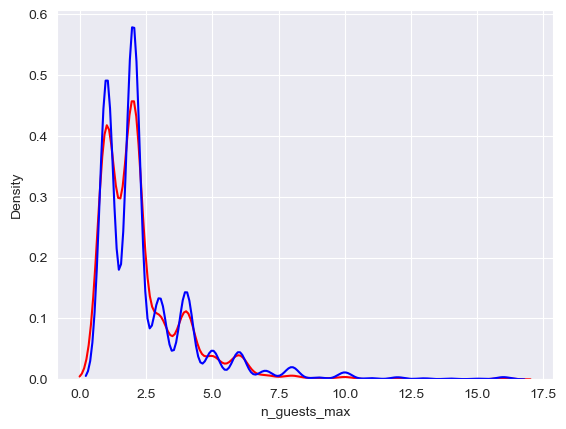

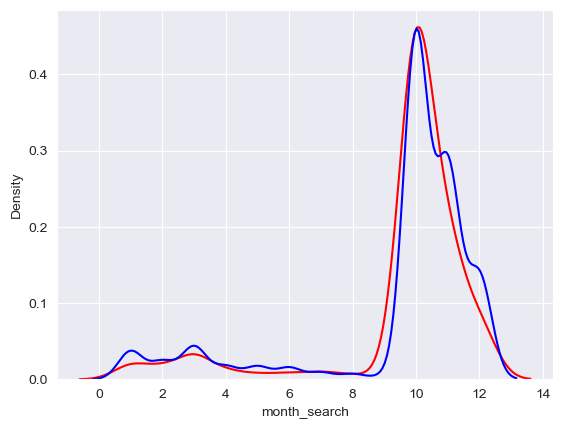

In [29]:
best_cluster_data = merged.loc[merged['cluster']==0]
other_data = merged.loc[merged['cluster']!=0]
ax = plt.subplots()[1]
# Compare the statistics for each features across groups
sn.kdeplot(data=best_cluster_data, x='n_guests_max', color='red', ax=ax)
sn.kdeplot(data=other_data, x='n_guests_max', color='blue', ax=ax)
plt.show(ax)
plt.close()

ax = plt.subplots()[1]
# Compare the statistics for each features across groups
sn.kdeplot(data=best_cluster_data, x='month_search', color='red', ax=ax)
sn.kdeplot(data=other_data, x='month_search', color='blue', ax=ax)
plt.show(ax)
plt.close()
    

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=69f32c3a-1666-4be0-997d-586065ca44e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>